**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 7**

**Problem 7.5**


**Use pvlib to estimate the single-diode model parameters for the LG345N1W-A5 module at STC. Compare them with the parameters you obtained in Problem 7.4. Finally, use pvlib again to plot the resulting I-V curve using 100 points and mark the maximum power point.**

*Hint: the function ivtools.sdm.fit_desoto fits the five single-diode model parameters to the I-V parameters provided by the manufacturer at STC. The function solves a system of non-linear equations using the optimize.root function of the Python Scipy library. It is recommended to use the Levenberg-Marquardt algorithm for convergence, passing the argument root_kwargs={"method": 'lm'} to the fit_desoto function. Also, note that the diode ideality factor is managed as a part of the product n·NS·VT (nNsVth or a parameters in pvlib) instead of just n. The functions pvlib.pvsystem.i_from_v or pvsystem.singlediode solve the single diode model for any input parameters to obtain the resulting I-V curve.*


We start by importing the package [pvlib](https://pvlib-python.readthedocs.io/en/stable/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results

In [7]:
import pvlib
import matplotlib.pyplot as plt

We define the values in the manufacturer's datasheet and use the funcion pvlib.ivtools.sdm.fit_desoto()

In [8]:
v_mp = 34.9 #V
i_mp = 9.89 #A
v_oc = 41.2 #V
i_sc= 10.57 #A

alpha_sc_rel = 0.03 #%/K
beta_voc_rel = -0.27 #%/K
'''pvlib.ivtools.sdm.fit_desoto expects thermal coefficients in absolute units [A/K] and [V/K], so the parameters given
by the manufacturer in relative units [%/K] need conversion
''' 
alpha_sc = alpha_sc_rel/100*i_sc #A/K
beta_voc = beta_voc_rel/100*v_oc #V/K
cells_in_series = 60 #Ns

# The I-V parameters are given at Standard Test Conditions
irrad_ref=1000
temp_ref=25

#The function requires knowledge of the solar cell technology. These values are used by default, which corresponds to c-Si
EgRef=1.121 # bandgap of c-Si cells [eV]
dEgdT=- 0.0002677 # Sensitivity of bandgap wtih temperature [eV/K]

single_diode_parameters = pvlib.ivtools.sdm.fit_desoto(v_mp, 
                             i_mp, 
                             v_oc, 
                             i_sc, 
                             alpha_sc, 
                             beta_voc, 
                             cells_in_series, 
                             EgRef, 
                             dEgdT, 
                             temp_ref, 
                             irrad_ref, 
                             root_kwargs={"method": 'lm'})

The 5 parameters for the single-diode model are:

In [9]:
I_L=single_diode_parameters[0]['I_L_ref'] #Photocurrent [A]
I_o=single_diode_parameters[0]['I_o_ref'] #Diode saturation current [A]
R_s=single_diode_parameters[0]['R_s'] #Series resistance [ohm]
R_sh=single_diode_parameters[0]['R_sh_ref'] #Parallel or shunt resistance Rp [ohm]
nNsVth=single_diode_parameters[0]['a_ref']  #Product of diode ideality factor (n), number of cells in series (Ns)
                                            # and thermal voltage Vt. 
#The diode ideality factor can be obtained as n = nNsVth / (Ns*Vt), where Vt = kT/q
kB=1.38066e-23 #J/K
q=1.60218e-19 #C
n=nNsVth/(cells_in_series*(kB*(temp_ref+273.15)/q))
#Print single-diode model parameters
print("IL =", round(float(I_L), 2), "(A)", "I0 =", "I0 =", '{:0.3e}'.format(float(I_o)), "(A)", "Rs =", round(float(R_s), 3), "(ohms)", "Rp =", round(float(R_sh), 1), "(ohms)", "n =", round(float(n), 2))


IL = 10.58 (A) I0 = I0 = 9.552e-12 (A) Rs = 0.16 (ohms) Rp = 139.6 (ohms) n = 0.96


Notice that the diode ideality factor is lower than 1 for fitting purposes, which has no physical sense. When fitting single-diode model parameters manually in P7.4, we assume n=1 for conventional c-Si modules. 

This difference in n explains the divergence in the value for I0 between the manual process and the pvlib function.

Once the parameters have been obtained, pvlib provides a function to compute the resulting I-V curve with any given number of data points. The user can choose between Lambert W exact solution or numerical optimization methods (Newton-Raphson or Brent’s bisection search).

In [10]:
IVcurve=pvlib.pvsystem.singlediode(photocurrent=I_L, 
                             saturation_current=I_o, 
                             resistance_series=R_s, 
                             resistance_shunt=R_sh,
                             nNsVth=nNsVth, 
                             ivcurve_pnts=100, 
                             method='lambertw')

Vmp = 34.9 (V) Imp = 9.89 (A) Pmax = 345.2 (W)


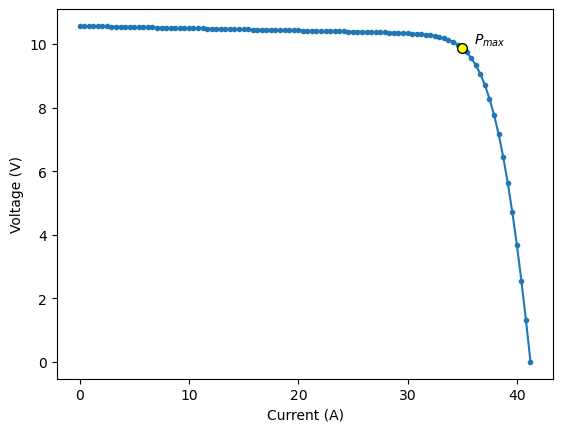

In [11]:
#Plot the I-V curve
plt.plot(IVcurve['v'],IVcurve['i'],'.-', label="I-V curve")
plt.ylabel('Voltage (V)')
plt.xlabel('Current (A)')

#Identify the values of the maximum power point to mark it on the graph
v_mp = IVcurve['v_mp']
i_mp = IVcurve['i_mp']

filled_marker_style = dict(marker='o', markersize=7,
                           color='darkgrey',
                           markerfacecolor='yellow',
                           markeredgecolor='black')
#Plot a marker at the maximum power point
plt.plot([v_mp], [i_mp], ls='', **filled_marker_style)
plt.annotate('$P_{max}$', xy=(36, 10), xycoords='data')

#Print Pmax values
print("Vmp =", round(float(v_mp), 2), "(V)", "Imp =", round(float(i_mp), 2), "(A)", "Pmax =", round(float(v_mp * i_mp), 1), "(W)")